# **Assignment 11**
# **The EUV wave height estimation from multi-point STEREO observations using epipolar geometry**

### **Data Analysis for Space Weather | Instructor: Prof Podladchikova | April, 2021**
### **by Victoria Krivova, Polina Starodumova**

The  objective  of  this assignment work is  tolearn  how  to  perform  3d  reconstructions  of EUV waves from multi-point STEREO observations.  EUV waves are large-scale disturbances in solar corona, that occur in association with coronal mass ejections (and solar flares). Additional important  outcome  of  this  exerciseis  the  experience  with  applications  of  methods  of  epipolar geometry for Stereo vision. 3-D reconstructions of EUV wave fronts are important for the deeper understanding of the physical nature of CME, forecast of the arrival of Earth-directed CME, and mitigation of space weather hazards.

In [3]:
from google.colab import files
uploaded = files.upload()

Saving 20071207_A_Dif_0435_0415.txt to 20071207_A_Dif_0435_0415.txt
Saving 20071207_B_Dif_0435_0415.txt to 20071207_B_Dif_0435_0415.txt


In [6]:
import pandas as pd
import numpy as np
import scipy
from math import sin
from math import cos
from math import sqrt
from numpy import genfromtxt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

We are going to study the event of December, 2007, on the EUV solar disk in 195 Angstrom as seen by the spacecraft STEREO A and B. Stereo-A sees outer side of westernwave front and inner side of easternwave front. Stereo-B sees outer side of easternwave front and inner side of westernwave front.

In [5]:
# reading images from spacecrafts
stereo_a = genfromtxt('20071207_A_Dif_0435_0415.txt')
stereo_b = genfromtxt('20071207_B_Dif_0435_0415.txt')

Let's define given data for the assignment:

In [279]:
au = 149597870.691 # distance between the Earth and Sun, km
R = 701407 # radius of Sun in km (from center of Sun to the atmosphere layer)

# STEREO A spacecraft
r_Sun_pix_a = 630 # radius of Sun in pixels

x_cen = 700 # pixel coordinates of the Sun center
y_cen = 700 

hel_lon_a = 20.620 * np.pi / 180 # heliographic longitude of the spacecraft, HEEQ, transformed to radians
hel_lat_a = -2.5350 * np.pi / 180 # heliographic latitude of the spacecraft, HEEQ, rad

dist_a = 0.966587 # heliospheric distance in AU

# STEREO B spacecraft
r_Sun_pix_b = 593 

hel_lon_b = -21.424 * np.pi / 180
hel_lat_b = 3.089 * np.pi / 180

dist_b = 1.026675

Helping functions:

Determine Cartesian coordinates of a point (M,N) in the coordinate system of a satellite (in km):

In [299]:
# nanleft - part of the grid on the left that does not cover the Sun 
# dist_top - distance from the top (grid start) to the Sun from the top 
# rad_circle - radiuses of circles at Sun parallels 
# R - radius of Sun atmosphere in km
# rad - radius of Sun in pixels
# Xcen, Ycen – pixel coordinates of the Sun center

def coord_pixel_to_real(i, j, nanleft, dist_top, rad_circle, R, rad, cenX, cenY):
    Y = -(cenX - j + 1) * (R / rad) 
    Z = (cenY - i + 1) * (R / rad) 
    X = sqrt(R ** 2 - Y ** 2 - Z ** 2) 
    return X, Y, Z

Determine pixel coordinates (i,j) from  the Cartesian coordinates:

In [212]:
def coord_real_to_pixel(rad, dist_top, nanleft, rad_circle, Y, Z, R):
    i = rad + dist_top - int(Z * (rad / R)) 
    j = int(nanleft[i - dist_top] + rad_circle[i - dist_top] + Y * (rad / R))
    return i,j

Transormation of coordinates of a point (in HEEQ) to the coordinate system of a satellite:

In [192]:
# Fi - Heliographic longitude, degrees 
# Theta - Heliographic latitude, degrees

def HEEQ_to_point_sat(Fi, Theta, X1, Y1, Z1):
    X = cos(Fi) * cos(Theta) * X1 + sin(Fi) * cos(Theta) * Y1 + sin(Theta) * Z1   
    Y = -sin(Fi) * X1 + cos(Fi) * Y1
    Z = -cos(Fi) * sin(Theta) * X1 - sin(Fi) * sin(Theta) * Y1 + cos(Theta) * Z1
    return X, Y, Z

Transormation of coordinates of point (X1, Y1, Z1) in a system of a satellite to HEEQ:

In [193]:
def point_sat_to_HEEQ(Fi, Theta, X1, Y1, Z1):
    X = cos(Fi) * cos(Theta) * X1 - sin(Fi) * Y1 - cos(Fi) * sin(Theta) * Z1 
    Y = sin(Fi) * cos(Theta) * X1 + cos(Fi) * Y1 - sin(Theta) * sin(Fi) * Z1    
    Z = sin(Theta) * X1 + cos(Theta) * Z1
    return X, Y, Z

Find radiuses of circle at the Sun parallels:

In [213]:
def rad_parallel_cut (rad):
    out = np.zeros(2*rad+1)
    out = out.T
    for it in range (1, rad+1):
        out[it] = int(np.sqrt((rad ** 2 - (rad - it + 1) ** 2)))    
    out = np.hstack((out, out[::-1]))
    return out   

Transform the coordinates (X1) of satellite A or B into the HEEQ system:

In [214]:
def to_HEEQ(X1, Fi, Theta):
    X = X1 * cos(Fi) * cos(Theta)
    Y = X1 * sin(Fi) * cos(Theta)    
    Z = X1 * sin(Theta)
    return X, Y, Z

Preprocessed base-difference images:

Text(0.5, 1.0, 'STEREO B data subset')

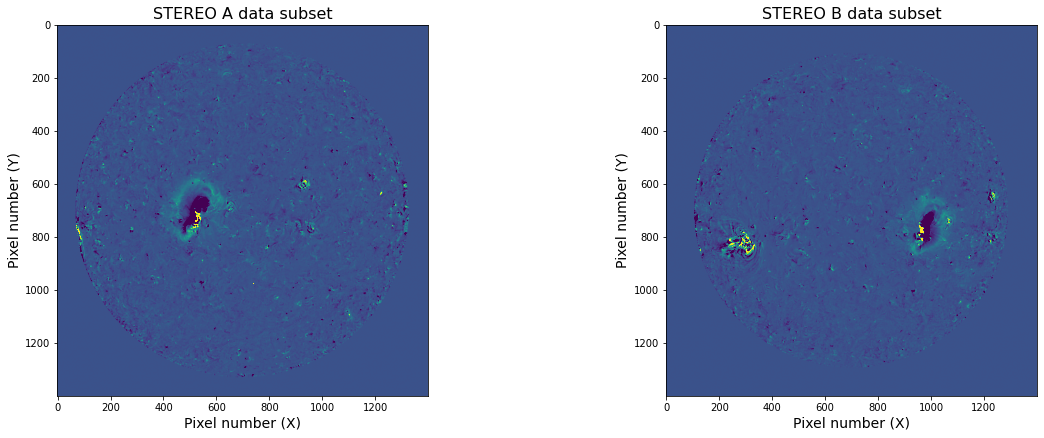

In [196]:
axis_font = {'fontname':'Arial', 'size':'14'}
title_font = {'fontname':'Arial', 'size':'16'} 

fig = plt.figure(figsize=(20, 15))

ax1 = fig.add_subplot(2, 2, 1)
ax1.set_xlabel('Pixel number (X)', **axis_font)
ax1.set_ylabel('Pixel number (Y)',  **axis_font)
ax1.imshow(stereo_a, norm=colors.Normalize(vmin=-100/3, vmax=300/3))
ax1.set_title('STEREO A data subset', **title_font)

ax2 = fig.add_subplot(2, 2, 2)
ax2.set_xlabel('Pixel number (X)', **axis_font)
ax2.set_ylabel('Pixel number (Y)',  **axis_font)
ax2.imshow(stereo_b, norm=colors.Normalize(vmin=-100/3, vmax=300/3))
ax2.set_title('STEREO B data subset', **title_font)

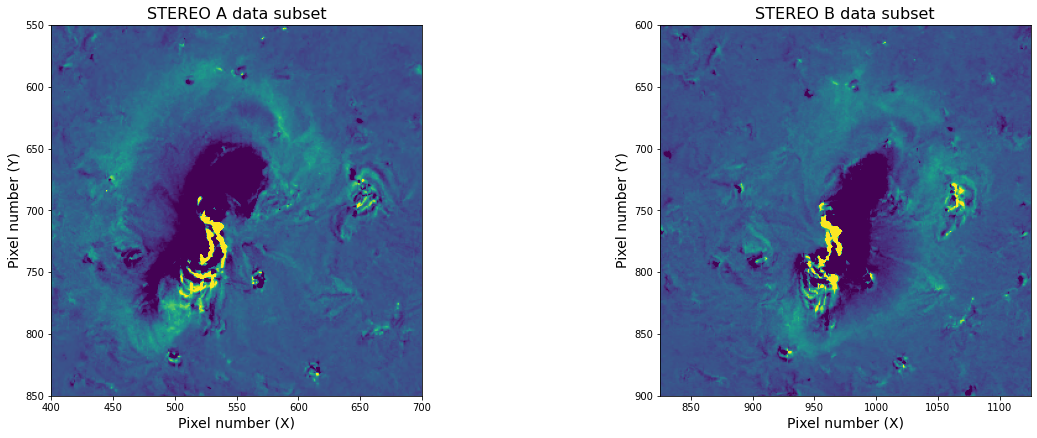

In [197]:
# area of interest

fig = plt.figure(figsize=(20, 15))

ax1 = fig.add_subplot(2, 2, 1)
ax1.set_xlabel('Pixel number (X)', **axis_font)
ax1.set_ylabel('Pixel number (Y)',  **axis_font)
ax1.imshow(stereo_a, norm=colors.Normalize(vmin=-100/3, vmax=300/3))
ax1.set_title('STEREO A data subset', **title_font)
ax1.set_ylim(550, 850)
ax1.set_xlim(400, 700)
ax1.invert_yaxis()

ax2 = fig.add_subplot(2, 2, 2)
ax2.set_xlabel('Pixel number (X)', **axis_font)
ax2.set_ylabel('Pixel number (Y)',  **axis_font)
ax2.imshow(stereo_b, norm=colors.Normalize(vmin=-100/3, vmax=300/3))
ax2.set_ylim(600, 900)
ax2.set_xlim(825, 1125)
ax2.set_title('STEREO B data subset', **title_font)
ax2.invert_yaxis()

In [215]:
# HEEQ, Cartesian coordinates of spacecrafts A and B in km
x_aa = dist_a * au
y_aa = 0
z_aa = 0

x_bb = dist_b * au
y_bb = 0
z_bb = 0

Notation below corresponds to lection charts:  
Point C – the height of EUV wave front.   
The line of sight from A (spacecraft) to C is crossed with a sphere in a point M.  
The line of sight from B (spacecraft) to C is crossed with a sphere in a point N. 

In [232]:
# manually choosing coordinates of the point of the wavecrest (in pixels), using stereo-B image

i_n = 667
j_n = 995

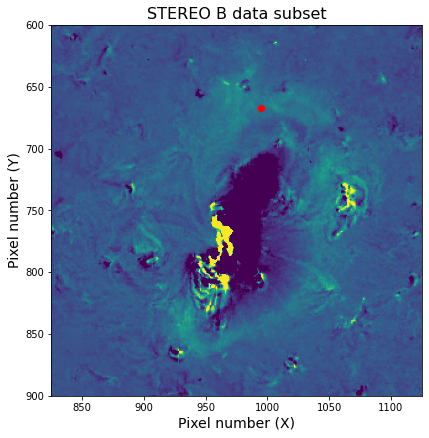

In [233]:
fig = plt.figure(figsize=(20, 15))

ax2 = fig.add_subplot(2, 2, 2)
ax2.set_xlabel('Pixel number (X)', **axis_font)
ax2.set_ylabel('Pixel number (Y)',  **axis_font)
ax2.imshow(stereo_b, norm=colors.Normalize(vmin=-100/3, vmax=300/3))
ax2.scatter(j_n, i_n, color='red')
ax2.set_ylim(600, 900)
ax2.set_xlim(825, 1125)
ax2.set_title('STEREO B data subset', **title_font)
ax2.invert_yaxis()

In [280]:
# deriving Cartesian coordinates of point N 

rad_circle_a = rad_parallel_cut(r_Sun_pix_a)
rad_circle_b = rad_parallel_cut(r_Sun_pix_b)
nanleft_a = x_cen - rad_circle_a
nanleft_b = x_cen - rad_circle_b
dist_top_a = y_cen - r_Sun_pix_a
dist_top_b = y_cen - r_Sun_pix_b

x_nb, y_nb, z_nb = coord_pixel_to_real(i_n, j_n, nanleft_b, dist_top_b, rad_circle_b, R, r_Sun_pix_b, x_cen, y_cen)

In [289]:
iM = []
jM = []

# pointing vectors in the coordinate system of stereo-B
l_bb = x_nb - x_bb
m_bb = y_nb - y_bb
n_bb = z_nb - z_bb

for k in range(1, 520):
    # determine the array of points C of wave crest, as viewed from STEREO-B
    x_cb = x_nb + (k-1) * 1250
    y_cb = m_bb / l_bb * (x_cb - x_bb) + y_bb
    z_cb = n_bb / l_bb * (x_cb - x_bb) + z_bb

    # transform coordinates of point C in the coordinate system of  STEREO-B to HEEQ
    x_c_heeq, y_c_heeq, z_c_heeq = point_sat_to_HEEQ(hel_lon_b, hel_lat_b, x_cb, y_cb, z_cb)

    # transform coordinates of point C in HEEQ to the coordinate system of STEREO-A
    x_ca, y_ca, z_ca = HEEQ_to_point_sat(hel_lon_a, hel_lat_a, x_c_heeq, y_c_heeq, z_c_heeq)

    # transfer this ensemble of points from STEREO-B to STEREO-A coordinate system and find the coordinates of M
    l_aa = x_ca - x_aa
    m_aa = y_ca - y_aa
    n_aa = z_ca - z_aa

    a = 1 + (m_aa / l_aa) ** 2 + (n_aa / l_aa) ** 2
    b = (x_aa + y_aa * m_aa / l_aa + z_aa * (n_aa / l_aa))
    c = - R**2 + x_aa ** 2 + y_aa ** 2 + z_aa ** 2 # equation of a sphere
    dt = b ** 2 - a * c
    if dt > 0:
        z_ma = (-x_aa * l_aa / n_aa + np.sqrt(abs((R**2*(l_aa**2+m_aa**2+n_aa**2)-x_aa**2*(m_aa**2+n_aa**2)))/(n_aa**2))) / ((l_aa**2+m_aa**2+n_aa**2)/n_aa**2)
        x_ma = z_ma * l_aa / n_aa + x_aa
        y_ma = z_ma * m_aa / n_aa
        
    else:   
        x_ma = 0
        y_ma = (-x_aa * m_aa)/ l_aa + y_aa
        z_ma = (-x_aa * n_aa)/ l_aa + z_aa

    iM1, jM1 = coord_real_to_pixel(r_Sun_pix_a, dist_top_a, nanleft_a, rad_circle_a, y_ma, z_ma, R)
    # ensemble of M points in pixels
    iM.append(iM1)
    jM.append(jM1)

# constructing epipolar line
i11 = iM[0]
i22 = iM[518]
j11 = jM[0]
j22 = jM[518]

k = (j22 - j11) / (i22 - i11)
b = j11 - k * i11

i1 = 0 
j1 = b
i2 = 1000
j2 = k*i2+b    

In [293]:
# choosing point on the epipolar line BN as viewed from STEREO-A
j_end = 490
i_end = (j_end-b)/k
i_end

597.1624365482234

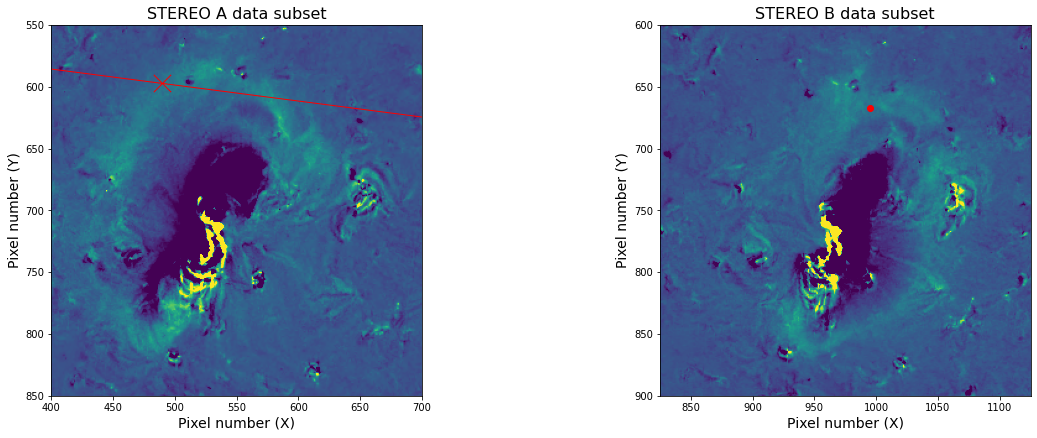

In [291]:
fig = plt.figure(figsize=(20, 15))

ax1 = fig.add_subplot(2, 2, 1)
ax1.set_xlabel('Pixel number (X)', **axis_font)
ax1.set_ylabel('Pixel number (Y)',  **axis_font)
ax1.imshow(stereo_a, norm=colors.Normalize(vmin=-100/3, vmax=300/3)) 
ax1.plot([j1,j2],[i1,i2],'red',linewidth=1)
ax1.scatter(j_end, i_end, c='red', marker='x',s = 300,linewidth=1)
ax1.set_ylim(550, 850)
ax1.set_xlim(400, 700)
ax1.invert_yaxis()
ax1.set_title('STEREO A data subset', **title_font)

ax2 = fig.add_subplot(2, 2, 2)
ax2.set_xlabel('Pixel number (X)', **axis_font)
ax2.set_ylabel('Pixel number (Y)',  **axis_font)
ax2.imshow(stereo_b, norm=colors.Normalize(vmin=-100/3, vmax=300/3))
ax2.scatter(j_n, i_n, color='red')
ax2.set_ylim(600, 900)
ax2.set_xlim(825, 1125)
ax2.set_title('STEREO B data subset', **title_font)
ax2.invert_yaxis()

In [292]:
j_end = 900
i_end = (j_end-b)/k
i_end

650.233502538071

In [300]:
# convert chosen coordinates back to Cartesian ones:
x_ma, y_ma, z_ma = coord_pixel_to_real(i_end, j_end, nanleft_a, dist_top_a, rad_circle_a, R, r_Sun_pix_a, x_cen, y_cen)

In [301]:
# transform coordinates of  STEREO-A, STEREO-B, M, N to HEEQ system
x_a_heeq, y_a_heeq, z_a_heeq = to_HEEQ(x_aa, hel_lon_a, hel_lat_a)
x_b_heeq, y_b_heeq, z_b_heeq = to_HEEQ(x_bb, hel_lon_b, hel_lat_b)
x_m_heeq, y_m_heeq, z_m_heeq = point_sat_to_HEEQ(hel_lon_a, hel_lat_a, x_ma, y_ma, z_ma)
x_n_heeq, y_n_heeq, z_n_heeq = point_sat_to_HEEQ(hel_lon_b, hel_lat_b, x_nb, y_nb, z_nb)

Determination of height of EUV wave:



In [302]:
# derive coordinates of C in HEEQ - solution of equations for BN and AM lines
laa = x_m_heeq - x_a_heeq
m_aa = y_m_heeq - y_a_heeq
n_aa = z_m_heeq - z_a_heeq
l_bb = x_n_heeq - x_b_heeq
m_bb = y_n_heeq - y_b_heeq
n_bb = z_n_heeq - z_b_heeq

x_c_heeq = (y_b_heeq - y_a_heeq - m_bb * x_b_heeq / l_bb + m_aa * x_a_heeq / l_aa) / (m_aa / l_aa - m_bb / l_bb)
y_c_heeq = m_aa*(x_c_heeq - x_a_heeq) / l_aa + y_a_heeq
z_c_heeq = n_aa*(x_c_heeq - x_a_heeq) / l_aa + z_a_heeq

h = sqrt(x_c_heeq ** 2 + y_c_heeq ** 2 + z_c_heeq ** 2) - R

In [312]:
print('Height is {} km'.format(round(h)))

Height is 157384 km


**Learning log:**

In this assignment we've worked with the 3D-reconstruction of EUV wave using images from separated satellites. The calculations were made in different coordinate systems (satellites and HEEQ) in order to define required points properly. What was also important is matching problem of the wave crest on STEREO images when the spacecrafts see various facets of the wave. As a result height of EUV wave was derived.  
Basically this method can be applied to many others phenomena on Sun. Significant issue is to correctly match points on solar surface obtained from different data sources.